# Método dos Elementos Finitos - Trabalho 2

Universidade Federal Fluminense

Disciplina ministrada pelo Prof. Marco Ferro

<marco.ferro@uol.com.br>

Aluno Noé de Lima

<noe_lima@id.uff.br>

Este trabalho visa aplicar o MEF a uma estrutura de treliças.

Primeiro semestre de 2020

\vfill

A célula a seguir configura o Jupyter-Notebook para exibir as equações matemáticas no formato do ambiente $\LaTeX$ e importa as bibliotecas necessárias.

In [1]:
%display latex
from numpy import angle,array,delete,isnan,nan,zeros
from numpy.linalg import norm,solve
import json
from sage.misc.latex import MathJax,latex_extra_preamble,png
from sage.plot.line import Line
latex.add_to_preamble('\\usepackage[english,brazil]{babel}')
!uname -a

Linux DESKTOP-CR7O8A2 4.19.104-microsoft-standard #1 SMP Wed Feb 19 06:37:35 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux


\cleardoublepage

\tableofcontents

\cleardoublepage

# Introdução

Este trabalho visa aplicar o MEF a uma estrutura de treliças.

Para tanto, deverá ler um arquivo em disco com os dados da treliça para resolver via código em Python.

Após ler o arquivo, o código abaixo gera um objeto de classe própria com as propriedades do sistema contido no arquivo.

# Teoria

A partir deste sistema, temos as seguintes equações diferenciais para o deslocamento $u$ da barra, considerando a aplicação de uma força Normal $F$:

In [2]:
# Declaração das variáveis independentes
x = var('x') # Variável independente (cumprimento)
var('F,N,E,A,L,i,j') # Variáveis simbólicas de apoio
# Considerações e Restrições das variáveis de apoio
assume(N,i,j,'integer') # Número inteiro de elementos
assume(L>0) # Comprimento da barra positivo
assume(N>0) # Pelo menos 1 Elemento
assume(E>0) # Módulo de elasticidade do material positivo
assume(A>0) # Área da seção transversal positiva
print(assumptions()) # Exibe um resumo das restrições asumidas até aqui
# Variáveis dependentes
u = function('u')(x) # Função analítica desconhecida u(x)
# Equações Diferenciais de u(x)
eq1 = E*A*diff(u,x,2) == 0
eq2 = E*A*diff(u,x) == F
eq1.show() # Exibe a equação diferencial de primeira ordem de u(x)
eq2.show() # Exibe a equação diferencial de segunda ordem de u(x)

[N is integer, i is integer, j is integer, L > 0, N > 0, E > 0, A > 0]


A*E*diff(u(x), x, x) == 0

A*E*diff(u(x), x) == F

A solução analítica destas equações, dadas abaixo, convergem para a equação conhecida da deformação linear na barra, que é:

\begin{equation*}
    u\left(x\right) = \frac{F}{EA}x
\end{equation*}

In [3]:
sol1 = u == desolve(eq1,u,ivar=x)
sol2 = u == desolve(eq2,u,ivar=x)
sol1.show() # Solução da EDO de 1 Ordem
sol2.show() # Solução da EDO de 2 Ordem

u(x) == _K2*x + _K1

u(x) == _C + F*x/(A*E)

A SRP - Sentença de Resíduos Ponderados, fornece a seguinte integral:

\begin{equation}
    \int_{D}{\phi_{i}R}dD = 0
\end{equation}

Onde,

\begin{equation*}
    R = \left(EA\frac{d^{2}\bar{u}}{dx^{2}}\right)
\end{equation*}

e,

\begin{equation*}
    \bar{u} = \sum_{n=1}^{N+1}u_{i}\phi_{i}
\end{equation*}

Assim, temos

\begin{equation*}
    \int_{0}^{L}{\phi_{i}\left(EA\frac{d^{2}\bar{u}}{dx^{2}}\right)}dx = 0
\end{equation*}


In [4]:
phi_i = function('phi_i')(x,i) # phi_i(x) da SRP
u_i = function('u_i')(i) # u_i
u_b = sum(u_i*phi_i,i,1,N+1) # û(x) estimado
R = (E*A*u_b.diff(x,2)).full_simplify() # Resíduo
u_b.show() # Exibe û
R.show() # Exibe o resíduo
SRP = (phi_i*R).integrate(x,0,L) # Sentença dos Resíduos Ponderados
SRP.show() # Exibe a SRP

sum(phi_i(x, i)*u_i(i), i, 1, N + 1)

(A*E*N + A*E)*u_i(i)*diff(phi_i(x, i), x, x)

(A*E*N + A*E)*integrate(phi_i(x, i)*diff(phi_i(x, i), x, x), x, 0, L)*u_i(i)

Deixando a solução analítica de lado, vamos à implementação

# Barra horizontal

## Matriz de Rigidez do Elemento

A matriz de Rigidez de uma barra dentro da treliça é dada por:

\begin{equation}
    K_{ij} = EA \int_{0}^{L}{\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx}\right)}dx
\end{equation}

## Vetor de Cargas Nodais do Elemento

\begin{equation}
    f_{i} = EA \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{L}
\end{equation}

Tem-se que:

\begin{equation}
    \left\{\begin{matrix}
        \phi_{1}\left(x\right) & = & \frac{L-x}{x} \\
        & & \\
        \phi_{2}\left(x\right) & = & \frac{x}{L}
    \end{matrix}\right.
\end{equation}

Logo, Simplificando tudo,

\begin{equation*}
    K_{11} = K_{22} = \frac{EA}{L}
\end{equation*}

\begin{equation*}
    K_{12} = K_{21} = -\frac{EA}{L}
\end{equation*}

Ou,

\begin{equation*}
    \mathbf{K}_{local} =
    \left[\begin{matrix}
        \frac{EA}{L} & -\frac{EA}{L} \\
        -\frac{EA}{L} & \frac{EA}{L}
    \end{matrix}\right]
\end{equation*}

Ou, ainda,

\begin{equation}
    \mathbf{K}_{local} = \frac{EA}{L}
    \left[\begin{matrix}
        1 & -1 \\
        -1 & 1
    \end{matrix}\right]
\end{equation}

E,

\begin{equation*}
    \vec{f}_{local} = F
    \left[\begin{matrix}
        -1 \\
        1
    \end{matrix}\right]
\end{equation*}


# Caso Geral - Barra em Qualquer Direção

\begin{equation*}
    N_{1} = \frac{h_{e}-x_{e}}{h_{e}}
\end{equation*}

\begin{equation*}
    N_{2} = \frac{x_{e}}{h_{e}}
\end{equation*}

\begin{equation*}
    N_{G} =
    \left[\begin{matrix}
        N_{1}cos{\alpha} & N_{1}sin{\alpha} & N_{2}cos{\alpha} & N_{2}sin{\alpha}
    \end{matrix}\right]
\end{equation*}

Logo,

\begin{equation*}
    \frac{\partial N}{\partial x} =
    \left[\begin{matrix}
        \frac{\partial N_{1}}{\partial x}cos{\alpha} & \frac{\partial N_{1}}{\partial x}sin{\alpha} & \frac{\partial N_{2}}{\partial x}cos{\alpha} & \frac{\partial N_{2}}{\partial x}sin{\alpha}
    \end{matrix}\right]
\end{equation*}

\begin{equation*}
    \frac{\partial N}{\partial x} =
    \left[\begin{matrix}
    -\frac{1}{h_{e}}cos{\alpha} & -\frac{1}{h_{e}}sin{\alpha} & \frac{1}{h_{e}}cos{\alpha} & \frac{1}{h_{e}}sin{\alpha}
    \end{matrix}\right]
\end{equation*}

\begin{equation*}
    \frac{\partial N}{\partial x} = \frac{1}{h_{e}}
    \left[\begin{matrix}
        -cos{\alpha} & -sin{\alpha} & cos{\alpha} & sin{\alpha}
    \end{matrix}\right]
    = \left[\mathbf{B}\right]
\end{equation*}

Bem como,

\begin{equation*}
    \left[k_{e}\right] =
    \int_{0}^{h_{e}}{EA\frac{\partial N_{i}}{\partial x}\frac{\partial N_{j}}{\partial x}}dx
\end{equation*}

Ou seja,

\begin{equation*}
    \left[k_{e}\right] =
    \int_{0}^{h_{e}}{\left[\mathbf{B^{T}}\right]EA\left[\mathbf{B}\right]}dx
\end{equation*}

Portanto,

\begin{equation*}
    \left[k_{e}\right] = \frac{EA}{h_{e}^{2}}
    \left[\begin{matrix}
        cos^{2}{(\alpha)} & sin{(\alpha)}cos{(\alpha)} & -cos^{2}{(\alpha)} & -sin{(\alpha)}cos{(\alpha)} \\
        sin{(\alpha)}cos{(\alpha)} & sin^{2}{(\alpha)} & -sin{(\alpha)}cos{(\alpha)} & -sin^{2}{(\alpha)} \\
        -cos^{2}{(\alpha)} & -sin{(\alpha)}cos{(\alpha)} & cos^{2}{(\alpha)} & sin{(\alpha)}cos{(\alpha)} \\
        -sin{(\alpha)}cos{(\alpha)} & -sin^{2}{(\alpha)} & sin{(\alpha)}cos{(\alpha)} & sin^{2}{(\alpha)}
    \end{matrix}\right]
    \int_{0}^{h_{e}}{}dx
    = \frac{EA}{h_{e}^{2}}
    \left[\mathbf{T}\right]
    \int_{0}^{h_{e}}{}dx
\end{equation*}

Onde $\mathbf{T}$ é a Matriz de Transformação ou de Rotação.

Logo,

\begin{equation*}
    \left[k_{e}\right] = \frac{EA}{h_{e}^{2}}
    \left[\mathbf{T}\right]
    \int_{0}^{h_{e}}{}dx =
    \left[
        \frac{EA}{h_{e}^{2}}\left[\mathbf{T}\right]x
    \right]_{0}^{h_{e}} =
    \frac{EA}{h_{e}^{2}}\left[\mathbf{T}\right]h_{e}   
\end{equation*}

Ou,

\begin{equation*}
    \left[k_{e}\right] = \frac{EA}{h_{e}}\left[\mathbf{T}\right]
\end{equation*}


# Exemplo 1 - Solução Manual

A seguir vamos resolver o sistema de treliça que será revisto no Exercício 1. Porém, aqui veremos a montagem do sistema manualmente. A descrição e o diagrama das treliças pode ser vista no desenho plotado e nos dados do Exercício 1 mais abaixo.

## Dados

O sistema plano é composto por três barras, sendo uma horizontal, entre os pontos de apoio, com $1~m$ de comprimento; uma barra vertical subindo a partir do segundo apoio, com $1~m$ de comprimento, e uma barra em diagonal fechando o triângulo. O apoio da esquerda é de segundo gênero, restringindo a translação em $x$ e $y$, e o apoio da direita, de primeiro gênero, restringindo a translação em $y$. Em todas as barras, temos $E\cdot A=10^{3}$ (produto do módulo de elasticidade do material pela área da seção transversal).


Assim, temos, por nome, as seguintes coordenadas dos Nós:

%latex
\begin{table}[!h]
    \centering
    \begin{tabular}{ccccccc}
        \hline
        \textbf{Nó} & \textbf{$(x$} & \textbf{,} & \textbf{$y)$} & \multicolumn{3}{c}{\textbf{Carga}} \\ \hline
        1           & (0            & ,          & 0)            & (0         & ,       & 0)          \\
        2           & (1            & ,          & 0)            & (0         & ,       & 0)          \\
        3           & (1            & ,          & 1)            & (1kN       & ,       & -1kN)       \\ \hline
    \end{tabular}
    \caption{Lista de Nós}\label{tab:01}
\end{table}

Assim, temos os seguintes Elementos:

%latex
\begin{table}[!h]
    \centering
    \begin{tabular}{ccc}
        \hline
        \textbf{Elemento} & \textbf{Do Nó} & \textbf{Para o Nó} \\ \hline
        1                 & 1              & 3                  \\
        2                 & 2              & 3                  \\
        3                 & 1              & 2                  \\ \hline
    \end{tabular}
    \caption{Lista de Elementos}\label{tab:02}
\end{table}

Seguindo a ordem $x~y$ e a numeração dos nós para as forças e deslocamentos, temos o seguintes vetores de forças nodais e deslocamentos:

\begin{equation*}
    \vec{f} =
    \left\{\begin{matrix}
        f_{x}^{1} \\ f_{y}^{1} \\ f_{x}^{2} \\ f_{y}^{2} \\ f_{x}^{3} \\ f_{y}^{3}
    \end{matrix}\right\}
\end{equation*}

e

\begin{equation*}
    \vec{u} =
    \left\{\begin{matrix}
        u_{x}^{1} \\ u_{y}^{1} \\ u_{x}^{2} \\ u_{y}^{2} \\ u_{x}^{3} \\ u_{y}^{3}
    \end{matrix}\right\}
\end{equation*}

Porém, as seguintes consições de contorno são prescritas:

\begin{equation*}
    \left\{\begin{matrix}
        u_{x}^{1} & = & 0 \\
        u_{y}^{1} & = & 0 \\
        u_{y}^{2} & = & 0
    \end{matrix}\right.
\end{equation*}

Bem como,

\begin{equation*}
    \left\{\begin{matrix}
        f_{x}^{2} & = & 0 \\
        f_{x}^{3} & = & 1kN \\
        f_{y}^{3} & = & -1kN
    \end{matrix}\right.
\end{equation*}

Assim, temos as seguintes Matrizes de Rigidez Local nos Elementos:

## Elemento 1

Temos, no Elemento 1, $\alpha = 45^{\circ}$ e, portanto, $\sin{\left(\alpha\right)} = \cos{\left(\alpha\right)} = \frac{\sqrt{2}}{2}$.

Logo,

\begin{equation*}
    \left[\mathbf{K}_{1}\right] = \frac{EA}{\sqrt{2}}\frac{1}{2}
    \left[\begin{matrix}
        1 & 1 & -1 & -1 \\
        1 & 1 & -1 & -1 \\
        -1 & -1 & 1 & 1 \\
        -1 & -1 & 1 & 1
    \end{matrix}\right]
\end{equation*}

In [5]:
var('EA')
K_1 = (EA/sqrt(2))*(1/2)*Matrix([[1,1,-1,-1],[1,1,-1,-1],[-1,-1,1,1],[-1,-1,1,1]])
print(K_1)

[ 1/4*sqrt(2)*EA  1/4*sqrt(2)*EA -1/4*sqrt(2)*EA -1/4*sqrt(2)*EA]
[ 1/4*sqrt(2)*EA  1/4*sqrt(2)*EA -1/4*sqrt(2)*EA -1/4*sqrt(2)*EA]
[-1/4*sqrt(2)*EA -1/4*sqrt(2)*EA  1/4*sqrt(2)*EA  1/4*sqrt(2)*EA]
[-1/4*sqrt(2)*EA -1/4*sqrt(2)*EA  1/4*sqrt(2)*EA  1/4*sqrt(2)*EA]


## Elemento 2

No Elemento 2, $\alpha = 90^{\circ}$ e, assim, $\sin{\left(\alpha\right)} = 1$ e $\cos{\left(\alpha\right)} = 0$. Logo,

\begin{equation*}
    \left[\mathbf{K}_{2}\right] = \frac{EA}{1}
    \left[\begin{matrix}
        0 & 0 & 0 & 0 \\
        0 & 1 & 0 & -1 \\
        0 & 0 & 0 & 0 \\
        0 & -1 & 0 & 1
    \end{matrix}\right]
\end{equation*}

In [6]:
K_2 = EA*Matrix([[0,0,0,0],[0,1,0,-1],[0,0,0,0],[0,-1,0,1]])
print(K_2)

[  0   0   0   0]
[  0  EA   0 -EA]
[  0   0   0   0]
[  0 -EA   0  EA]


## Elemento 3

Por fim, no Elemento 3, temos $\alpha = 0^{\circ}$ e, consequentemente, $\sin{\left(\alpha\right)} = 0$ e $\cos{\left(\alpha\right)} = 1$. Assim,

\begin{equation*}
    \left[\mathbf{K}_{3}\right] = \frac{EA}{1}
    \left[\begin{matrix}
        1 & 0 & -1 & 0 \\
        0 & 0 & 0 & 0 \\
        -1 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0
    \end{matrix}\right]
\end{equation*}

In [7]:
K_3 = EA*Matrix([[1,0,-1,0],[0,0,0,0],[-1,0,1,0],[0,0,0,0]])
print(K_3)

[ EA   0 -EA   0]
[  0   0   0   0]
[-EA   0  EA   0]
[  0   0   0   0]


## Matriz de Rigidez Global

In [8]:
K_G = Matrix(SR,6,6) # Matriz 6 x 6

K_G[0:2,0:2] = K_1[0:2,0:2] + K_3[0:2,0:2] # K_G(11) = K_1(11) + K_3(11)
K_G[0:2,2:4] = K_3[0:2,2:4]                # K_G(12) = K_3(12)
K_G[0:2,4:6] = K_1[0:2,2:4]                # K_G(13) = K_1(12)
K_G[2:4,0:2] = K_3[0:2,2:4]                # K_G(21) = K_3(12)
K_G[2:4,2:4] = K_2[0:2,0:2] + K_3[2:4,2:4] # K_G(22) = K_2(11) + K_3(22)
K_G[2:4,4:6] = K_2[0:2,2:4]                # K_G(23) = K_2(12)
K_G[4:6,0:2] = K_1[0:2,2:4]                # K_G(31) = K_1(12)
K_G[4:6,2:4] = K_2[0:2,2:4]                # K_G(32) = K_2(12)
K_G[4:6,4:6] = K_1[2:4,2:4] + K_2[2:4,2:4] # K_G(33) = K_1(22) + K_2(22)

print(K_G)

[1/4*sqrt(2)*EA + EA      1/4*sqrt(2)*EA                 -EA                   0     -1/4*sqrt(2)*EA     -1/4*sqrt(2)*EA]
[     1/4*sqrt(2)*EA      1/4*sqrt(2)*EA                   0                   0     -1/4*sqrt(2)*EA     -1/4*sqrt(2)*EA]
[                -EA                   0                  EA                   0                   0                   0]
[                  0                   0                   0                  EA                   0                 -EA]
[    -1/4*sqrt(2)*EA     -1/4*sqrt(2)*EA                   0                   0      1/4*sqrt(2)*EA      1/4*sqrt(2)*EA]
[    -1/4*sqrt(2)*EA     -1/4*sqrt(2)*EA                   0                 -EA      1/4*sqrt(2)*EA 1/4*sqrt(2)*EA + EA]


Aplicando as condições de contorno, podemos rearrumar e simplificar a equação $\mathbf{K}\vec{u}=\vec{f}$.

A solução do sistema modificado encontrará o vetor a seguir:

\begin{equation*}
    \left\{\begin{matrix}
        f_{x}^{1} \\ f_{y}^{1} \\ u_{x}^{2} \\ f_{y}^{2} \\ u_{x}^{3} \\ u_{y}^{3}
    \end{matrix}\right\}
\end{equation*}

In [9]:
I = Matrix.identity(SR,6)
f = vector([0,0,0,0,1,-1])
Km = K_G
Km[:,0] = -I[:,0]
I[:,0] = -0*K_G[:,0]
Km[:,1] = -I[:,1]
I[:,1] = -0*K_G[:,1]
Km[:,3] = -I[:,3]
I[:,3] = -0*K_G[:,3]

print(Km\(I*f)) # Solução do Sistema Modificado

(-1, -1, 0, 2, 2*sqrt(2)/EA + 2/EA, -2/EA)


Portanto,

\begin{equation*}
    \begin{matrix}
        f_{x}^{1} & = & -1kN \\
        f_{y}^{1} & = & -1kN \\
        u_{x}^{2} & = & 0 \\
        f_{y}^{2} & = & 2kN \\
        u_{x}^{3} & = & \frac{2+2\sqrt{2}}{EA} \\
        u_{y}^{3} & = & -\frac{2}{EA}
    \end{matrix}
\end{equation*}

Ou, ainda,

\begin{equation*}
    \vec{u} =
    \left\{\begin{matrix}
        u_{x}^{1} \\ u_{y}^{1} \\ u_{x}^{2} \\ u_{y}^{2} \\ u_{x}^{3} \\ u_{y}^{3}
    \end{matrix}\right\} =
    \left\{\begin{matrix}
        0 \\ 0 \\ 0 \\ 0 \\ \frac{2+2\sqrt{2}}{EA} \\ -\frac{2}{EA}
    \end{matrix}\right\}
\end{equation*}

E

\begin{equation*}
    \vec{f} =
    \left\{\begin{matrix}
        f_{x}^{1} \\ f_{y}^{1} \\ f_{x}^{2} \\ f_{y}^{2} \\ f_{x}^{3} \\ f_{y}^{3}
    \end{matrix}\right\} =
    \left\{\begin{matrix}
        -1kN \\ -1kN \\ 0 \\ 2kN \\ 1kN \\ -1kN
    \end{matrix}\right\}
\end{equation*}

Para encontrar os esforços nas barras, utilizamos:

\begin{equation*}
    N = \frac{EA}{L}
    \left[\begin{matrix}
        -\cos{\left(\alpha\right)} & -\sin{\left(\alpha\right)} & \cos{\left(\alpha\right)} & \sin{\left(\alpha\right)}
    \end{matrix}\right] u_{e}
\end{equation*}


## Tensão na Barra 1

Na barra 1, $\alpha=45^{\circ}$, portanto, $\sin{\left(\alpha\right)}=\cos{\left(\alpha\right)}=\frac{\sqrt{2}}{2}$ e $L=\sqrt{2}$.

In [10]:
u_1 = vector([0,0,(2+2*sqrt(2))/EA,-2/EA])
N_1 = (EA/sqrt(2))*vector([-cos(pi/4),-sin(pi/4),cos(pi/4),sin(pi/4)])
print(N_1*u_1)

sqrt(2)


## Tensão na Barra 2

Na barra 2, $\alpha=90^{\circ}$, portanto, $\sin{\left(\alpha\right)}=1$, $\cos{\left(\alpha\right)}=0$ e $L=1$.

In [11]:
u_2 = vector([0,0,(2+2*sqrt(2))/EA,-2/EA])
N_2 = EA*vector([-cos(pi/2),-sin(pi/2),cos(pi/2),sin(pi/2)])
print(N_2*u_2)

-2


## Tensão na Barra 3

Na barra 3, $\alpha=0^{\circ}$, portanto, $\sin{\left(\alpha\right)}=0$, $\cos{\left(\alpha\right)}=1$ e $L=1$.

In [12]:
u_3 = vector([0,0,0,0])
N_3 = EA*vector([-cos(0),-sin(0),cos(0),sin(0)])
print(N_3*u_3)

0


Temos, portanto, $\sqrt{2}~kN$ de Tração no Elemento 1, $2~kN$ de Compressão no Elemento 2 e $0$ no Elemento 3.

# Implementação do Código

A função abaixo lê um arquivo JSON, cujo endereço relativo está na variável $path$, e retorna o conteúdo como um dicionário Python na variável $file$.

In [13]:
def readjson(path):
    file = None
    try:
        with open(path,'r') as f:
            file = json.load(f)
    except IOError as err:
        print('File Error: ' + str(err))
    except JSONDecodeError as err:
        print('JSON Error: ' + str(err))
    finally:
        return file

Será criada, a seguir, uma classe chamada $node$ para armazenar os elementos do tipo Nó, contendo as informações necessárias para a definição da localização e tipo de apoio existente.

In [14]:
class node:
    def __init__(self,x=0.0,y=0.0,z=0.0,tag=''):
        self.dot = array([x,y,z])
        self.l = zeros([3])
        self.u = zeros([3])
        self.s = array([False,False,False])
        self.tag = tag
    
    def support(self,rx,ry,rz):
        self.s = array([rx,ry,rz])
        
    def load(self,fx,fy,fz):
        self.l = array([fx,fy,fz])
        
    def uloc(self, ul):
        self.u = ul

Após a definição dos Nós, agora será criada uma classe para armazenar as barras (colunas, vigas) que compõem a treliça.

In [15]:
class bar:
    def __init__(self,no1,no2,EA,tag=''):
        self.at = no1.dot # Origem da barra
        self.vec = no2.dot - no1.dot # Vetor (x,y) da barra
        self.EA = EA # Módulo de Elasticidade x área da seção transversal
        self.tag = tag # Nome de referência para a barra
        
    def K(self):
        L = norm(self.vec)
        dx = self.vec[0]
        dy = self.vec[1]
        B = array([[-dx,-dy,dx,dy]])/L
        return B.T*(self.EA/L)*B # Matriz de Rigidez Local
    
    def K11(self):
        L = norm(self.vec)
        B = array([[self.vec[0],self.vec[1]]])/L
        return B.T*(self.EA/L)*B
    
    def K12(self):
        return -K11(self)
    
    def K21(self):
        return -K11(self)
    
    def K22(self):
        return K11(self)

Por último, uma classe geral contendo a treliça em si, com os nós e suas respectivas barras.

Dentro da classe $trelica$ também estára o método para calcular a matriz de rigidez $K$ e a solução do sistema pelo método dos deslocamentos.

In [16]:
class trelica:
    def __init__(self, file):
        self.n = file['n']
        self.m = 0 # Número de barras
        self.E = array(file['E'])
        self.A = array(file['A'])
        cargas = array(file['loads'])
        self.nos = []
        self.barras = []
        self.K = zeros([2*self.n,2*self.n])
        self.f = zeros([2*self.n])
        self.u = zeros([2*self.n])
        for name, value in file['nodes'].items():
            no = node(value['x'],
                      value['y'],
                      value['z'],
                      name)
            no.support(value['Tx'],
                      value['Ty'],
                      value['Tz'],)
            self.nos.append(no)
        for i in range(self.n):
            self.nos[i].load(cargas[i][0],
                      cargas[i][1],
                      cargas[i][2])
            # Cálculo dos Vetores u e f
            ff = array([self.nos[i].l[0],self.nos[i].l[1]])
            uu = array([nan,nan])
            if self.nos[i].s[0]:
                uu[0] = 0
                ff[0] = nan
            if self.nos[i].s[1]:
                uu[1] = 0
                ff[1] = nan
            self.f[2*i:2*i+2] = ff
            self.u[2*i:2*i+2] = uu
            for j in range(i,self.n):
                EA = self.E[i,j]*self.A[i,j]
                if EA:
                    barra = bar(self.nos[i],self.nos[j],EA)
                    self.m += 1 # Conta as barras
                    self.barras.append(barra)
                    # Cálculo da Matriz k
                    k = barra.K11()
                    self.K[2*i:2*i+2,2*i:2*i+2] += k
                    self.K[2*i:2*i+2,2*j:2*j+2] -= k
                    self.K[2*j:2*j+2,2*i:2*i+2] -= k
                    self.K[2*j:2*j+2,2*j:2*j+2] += k
        
    def deslocamentos(self):
        K,u,f = self.K,self.u,self.f
        change = True
        m = 2*self.n
        while change:
            change = False
            for i in range(m):
                if isnan(f[i]):
                    f -= u[i]*K[:,i]
                    K[:,i] = zeros(m)
                    K[i,i] = -1
                    K = delete(K,i,0)
                    K = delete(K,i,1)
                    u = delete(u,i)
                    f = delete(f,i)
                    change = True
                    m -= 1
                    break
        u = solve(K,f)
        k = 0
        desloc = self.u.copy()
        for i in range(2*self.n):
            if isnan(desloc[i]):
                desloc[i] = u[k]
                k += 1
        forces = self.K.dot(desloc) # Recalcula as forças nodais a partir dos deslocamentos
        for i in range(self.n):
            self.nos[i].uloc(array([desloc[2*i],desloc[2*i+1],0]))
            print('Nó: (',self.nos[i].dot[0],',',self.nos[i].dot[1],'):')
            print('Fx =', forces[2*i], 'kN, Fy =', forces[2*i+1],'kN')
            print('dx =', 1000*desloc[2*i], 'mm, dy =', 1000*desloc[2*i+1],'mm\n\n')
        return
    
    def tensoes(self):
        self.deslocamentos()
        for i in range(self.n):
            for j in range(i,self.n):
                EA = self.E[i,j]*self.A[i,j]
                if EA:
                    c = self.nos[j].dot[0] - self.nos[i].dot[0] # delta x da barra
                    s = self.nos[j].dot[1] - self.nos[i].dot[1] # delta y da barra
                    L = norm(array([c,s]))
                    Bl = array([-c,-s,c,s])/L
                    ul = array([self.nos[i].u[0],self.nos[i].u[1],self.nos[j].u[0],self.nos[j].u[1]])
                    N = (EA/L)*Bl.dot(ul)
                    if N > 0:
                        print('A Barra do Nó (', self.nos[i].dot[0], ',', self.nos[i].dot[1], ') para o Nó (', self.nos[j].dot[0], ',', self.nos[j].dot[1], ') está sujeita a uma tração de', N, 'kN\n\n')
                    elif N < 0:
                        print('A Barra do Nó (', self.nos[i].dot[0], ',', self.nos[i].dot[1], ') para o Nó (', self.nos[j].dot[0], ',', self.nos[j].dot[1], ') está sujeita a uma compressão de', N, 'kN\n\n')
                    else:
                        print('A Barra do Nó (', self.nos[i].dot[0], ',', self.nos[i].dot[1], ') para o Nó (', self.nos[j].dot[0], ',', self.nos[j].dot[1], ') está sem carregamento\n\n')
        return
    
    def desenha(self):
        p = line([])
        for i in range(self.m):
            p += line([self.barras[i].at[0:-1], self.barras[i].at[0:-1]+self.barras[i].vec[0:-1]])
        return p

# Exercício 1 - Sistema Com 3 Barras

O arquivo a ser lido está no formato JSON e será armazenado na variável $parser$.

A partir do valor no arquivo JSON, em $parser$, será criada a treliça e armazenada em $tr$

{
    "A": [
        [
            0.0,
            1.0,
            1.0
        ],
        [
            1.0,
            0.0,
            1.0
        ],
        [
            1.0,
            1.0,
            0.0
        ]
    ],
    "E": [
        [
            0.0,
            1000.0,
            1000.0
        ],
        [
            1000.0,
            0.0,
            1000.0
        ],
        [
            1000.0,
            1000.0,
            0.0
        ]
    ],
    "dim": 2,
    "loads": [
        [
            0.0,
            0.0,
            0.0
        ],
        [
            0.0,
            0.0,
            0.0
        ],
        [
            1.0,
            -1.0,
            0.0
        ]
    ],
    "n": 3,
    "nodes": {
        "No 1": {
            "Mx": false,
            "My": false,
            "Mz": false,
            "Tx": true,
            "Ty": true,
            "Tz": false,
            "x": 0.0,
            "y": 0.0,
            "z": 0.0
        },
  

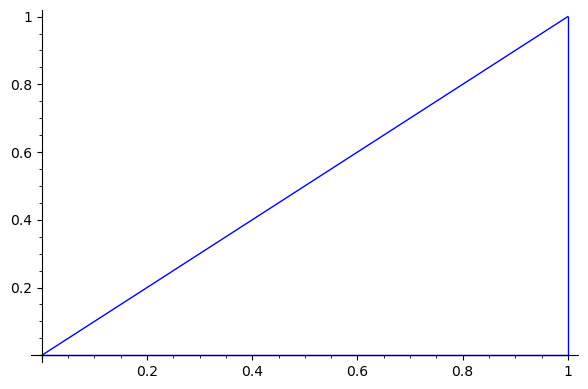

Nó: ( 0.0 , 0.0 ):
Fx = -1.0 kN, Fy = -1.0 kN
dx = 0.0 mm, dy = 0.0 mm


Nó: ( 1.0 , 0.0 ):
Fx = 0.0 kN, Fy = 2.0 kN
dx = 0.0 mm, dy = 0.0 mm


Nó: ( 1.0 , 1.0 ):
Fx = 1.0 kN, Fy = -1.0 kN
dx = 4.828427124746192 mm, dy = -2.0 mm


A Barra do Nó ( 0.0 , 0.0 ) para o Nó ( 1.0 , 0.0 ) está sem carregamento


A Barra do Nó ( 0.0 , 0.0 ) para o Nó ( 1.0 , 1.0 ) está sujeita a uma tração de 1.4142135623730956 kN


A Barra do Nó ( 1.0 , 0.0 ) para o Nó ( 1.0 , 1.0 ) está sujeita a uma compressão de -2.0 kN




In [17]:
parser3n = readjson("trelica3nos.json")
print(json.dumps(parser3n, indent=4, sort_keys=True)) # Exibir conteúdo do arquivo lido
trel3n = trelica(parser3n) # Treliça de 3 nós para teste
trel3n.desenha().show() # Desenha as barras da estrutura
trel3n.tensoes() # apresenta os deslocamentos nos nós, reações de apoio e carregamento nas barras

# Exercício 2 - Sistema Com 6 Barras

O exemplo a seguir contém 4 nós e 6 barras.

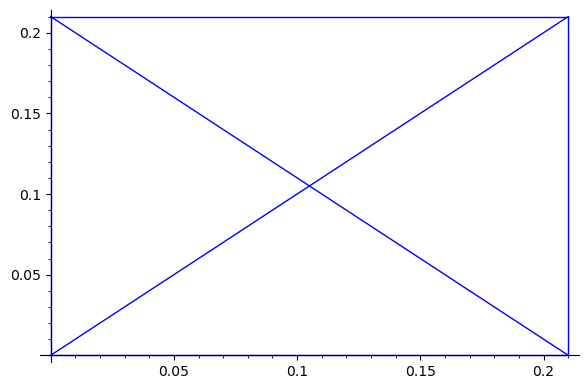

Nó: ( 0.0 , 0.0 ):
Fx = 9.999999999999996 kN, Fy = 5.714285714285713 kN
dx = 0.0 mm, dy = 0.0 mm


Nó: ( 0.0 , 0.21 ):
Fx = -9.999999999999995 kN, Fy = 4.285714285714283 kN
dx = 0.0 mm, dy = 0.0 mm


Nó: ( 0.21 , 0.21 ):
Fx = 0.0 kN, Fy = -10.000000000000005 kN
dx = 5.714285714285712 mm, dy = -17.14285714285714 mm


Nó: ( 0.21 , 0.0 ):
Fx = -8.881784197001252e-16 kN, Fy = 3.552713678800501e-15 kN
dx = -4.285714285714283 mm, dy = -12.857142857142852 mm


A Barra do Nó ( 0.0 , 0.0 ) para o Nó ( 0.0 , 0.21 ) está sem carregamento


A Barra do Nó ( 0.0 , 0.0 ) para o Nó ( 0.21 , 0.21 ) está sujeita a uma compressão de -8.081220356417683 kN


A Barra do Nó ( 0.0 , 0.0 ) para o Nó ( 0.21 , 0.0 ) está sujeita a uma compressão de -4.285714285714283 kN


A Barra do Nó ( 0.0 , 0.21 ) para o Nó ( 0.21 , 0.21 ) está sujeita a uma tração de 5.714285714285712 kN


A Barra do Nó ( 0.0 , 0.21 ) para o Nó ( 0.21 , 0.0 ) está sujeita a uma tração de 6.060915267313262 kN


A Barra do Nó ( 0.21 , 0.21 ) p

In [18]:
trel4n = trelica(readjson("trelica4nos.json")) # Treliça de 4 nós para teste
trel4n.desenha().show() # Desenha as barras da estrutura
trel4n.tensoes() # apresenta os deslocamentos nos nós, reações de apoio e carregamento nas barras

# Exercício 3 - Sistema Com 13 Barras

O exemplo a seguir contém 8 nós e 13 barras.

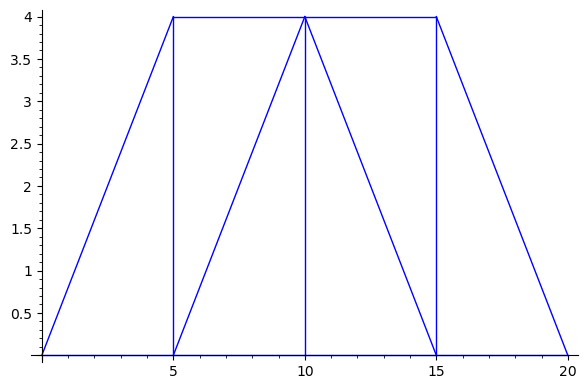

Nó: ( 0.0 , 0.0 ):
Fx = 0.0 kN, Fy = 59.99999999999997 kN
dx = 0.0 mm, dy = 0.0 mm


Nó: ( 5.0 , 0.0 ):
Fx = 0.0 kN, Fy = -30.000000000000114 kN
dx = 374.99999999999994 mm, dy = -2865.105351505299 mm


Nó: ( 10.0 , 0.0 ):
Fx = 5.684341886080802e-14 kN, Fy = -59.999999999999886 kN
dx = 937.4999999999994 mm, dy = -4300.470527257947 mm


Nó: ( 15.0 , 0.0 ):
Fx = -1.7053025658242404e-13 kN, Fy = -30.0 kN
dx = 1499.9999999999984 mm, dy = -2865.1053515052977 mm


Nó: ( 20.0 , 0.0 ):
Fx = -5.684341886080802e-14 kN, Fy = 59.99999999999994 kN
dx = 1874.999999999998 mm, dy = 0.0 mm


Nó: ( 15.0 , 4.0 ):
Fx = -5.684341886080802e-14 kN, Fy = -1.1368683772161603e-13 kN
dx = 562.4999999999994 mm, dy = -2625.1053515052977 mm


Nó: ( 10.0 , 4.0 ):
Fx = 1.7053025658242404e-13 kN, Fy = -2.2737367544323206e-13 kN
dx = 937.4999999999992 mm, dy = -4060.470527257947 mm


Nó: ( 5.0 , 4.0 ):
Fx = 2.842170943040401e-14 kN, Fy = -1.1368683772161603e-13 kN
dx = 1312.499999999999 mm, dy = -2625.105351505299 mm




In [19]:
trel8n = trelica(readjson("trelica8nos.json")) # Treliça de 8 nós para teste
trel8n.desenha().show() # Desenha as barras da estrutura
trel8n.tensoes() # apresenta os deslocamentos nos nós, reações de apoio e carregamento nas barras